<a href="https://colab.research.google.com/github/VictorZuanazzi/Auto-Trade-Crypto-Bot/blob/master/Mahsa_and_Victor_NLP1_Practical_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practical 1: Sentiment Detection of Movie Reviews
========================================



This practical concerns sentiment detection of movie reviews.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task (how might one go about classifying the texts?); you will write
code that decides whether a random unseen movie review is positive or
negative.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Bo Pang’s system. If you have questions about it,
we should resolve them in our first demonstrated practical.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

**Environment**

All code should be written in **Python 3**. 
If you use Colab, check if you have that version with `Runtime -> Change runtime type` in the top menu.

> If you want to work in your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.

#### Learning Python 3

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

Loading the Data
-------------------------------------------------------------

In [1]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2018-11-23 08:14:30--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.1’

sent_lexicon.1      100%[===================>] 647.05K  --.-KB/s    in 0.06s   

2018-11-23 08:14:30 (9.88 MB/s) - ‘sent_lexicon.1’ saved [662577/662577]

--2018-11-23 08:14:31--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)

In [0]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# load reviews into memory
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

# For documentation on POS-tags, see 
# https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print(len(reviews))

def print_sentence_with_pos(s):
  print(s)
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("#types", len(c))

print("Most common tokens:")
for token, count in c.most_common(25):
  print("%10s : %8d" % (token, count))
  


2000
0 NEG 29
[['Two', 'CD'], ['teen', 'JJ'], ['couples', 'NNS'], ['go', 'VBP'], ['to', 'TO'], ['a', 'DT'], ['church', 'NN'], ['party', 'NN'], [',', ','], ['drink', 'NN'], ['and', 'CC'], ['then', 'RB'], ['drive', 'NN'], ['.', '.']]
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
[['Damn', 'JJ'], ['that', 'IN'], ['Y2K', 'CD'], ['bug', 'NN'], ['.', '.']]
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
[['It', 'PRP'], ['is', 'VBZ'], ['movies', 'NNS'], ['like', 'IN'], ['these', 'DT'], ['that', 'WDT'], ['make', 'VBP'], ['a', 'DT'], ['jaded', 'JJ'], ['movie', 'NN'], ['viewer', 'NN'], ['thankful', 'JJ'], ['for', 'IN'], ['the', 'DT'], ['invention', 'NN'], ['of', 'IN'], ['the', 'DT'], ['Timex', 'NNP'], ['IndiGlo', 'NNP'], ['watch', 'NN'], ['.', '.']]
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 1

Symbolic approach – sentiment lexicon (2pts)
---------------------------------------------------------------------



**How** could one automatically classify movie reviews according to their
sentiment? 

If we had access to a **sentiment lexicon**, then there are ways to solve
the problem without using Machine Learning. One might simply look up
every open-class word in the lexicon, and compute a binary score
$S_{binary}$ by counting how many words match either a positive, or a
negative word entry in the sentiment lexicon $SLex$.

$$S_{binary}(w_1w_2...w_n) = \sum_{i = 1}^{n}\text{sgn}(SLex\big[w_i\big])$$

**Threshold.** In average there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1w_2...w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{else }
        \end{array}
$$

To implement this approach, you should use the sentiment
lexicon in `sent_lexicon`, which was taken from the
following work:

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

#### (Q: 1.1) Implement this approach and report its classification accuracy. (1 pt)

In [0]:
threshold= 8
switch = 'binary'   #takes the value 'weighted' or 'binary'
        
def classify(S,threshold):
  '''classify 1 if S > treshold and 0 otherwise'''
  # classifies one review as positive (1) or negative (0)
  if S > threshold:
    return 1 #positive
  else:
    return 0 #negative
  
def calculate_word_score(switch,token_value):
  # switch function: calculates the score of each word with either 
  # the weighted or binary formula
  if switch=='weighted':
    return token_value[0]*token_value[1]
  if switch=='binary':
    return token_value[0]

def load_lexicon():
  # loads lexicon in the memory
  lexicon = []
  with open("sent_lexicon", mode="r+", encoding="utf-8") as f:
    for line in f:
      lexicon.append(line.split(" "))
  return lexicon

# creates a dictionary of sentiment of the words
def gimme_word_sentiment(lexicon):
  # Returns a dictionary in the format:
  #    word: [sentiment, magnitude]
  #    sentiment can take 1 or -1
  #    magnitude can take 1 or 2
  word_dict  = {}     # dictionary of the format "word": [sentiment, magnitude]
  weight_strong = 2   
  weight_weak = 1
  negative_sentiment = -1
  positive_sentiment = 1
  both_neutral = 0
  for i in range(len(lexicon)):
    token = lexicon[i][2][len("word1="):]
    polarity_text = lexicon[i][5]
    if (polarity_text.find("negative") != -1):
      word_dict[token]= [negative_sentiment]
    elif (polarity_text.find("positive") != -1):
      word_dict[token]= [positive_sentiment]
    else: 
      word_dict[token] = [both_neutral]
    magnitude_text = lexicon[i][0]
    if (magnitude_text.find("strongsubj") != -1):
      word_dict[token].append(weight_strong)
    else:
      word_dict[token].append(weight_weak)
    #print(token, ": ", word_dict[token], "lexicon: ", lexicon[i])
  return word_dict

def review_score_calculator(reviews, word_dict, switch):
  S = np.zeros(len(reviews))
  c=0
  for review in reviews:
    count_token = 0
    for sentence in review["content"]:
      for token, pos_tag in sentence:
        token = token.lower()
        token_value = word_dict.get(token)
        if token_value is not None:
          S[c] = S[c] + calculate_word_score(switch, token_value)
    c += 1
  return S

lexicon = load_lexicon()
word_dict = gimme_word_sentiment(lexicon)

# loads the reviews in the memory
with open("reviews.json", mode="r", encoding="utf-8") as h:
  reviews = json.load(h)

S_binary = review_score_calculator(reviews,word_dict,switch)

#classifying the reviews
classified_reviews=np.zeros(len(reviews))
for i in range(len(reviews)):
  classified_reviews[i]=classify(S_binary[i],threshold)
             

In [5]:
debug = False

def evaluate_model(reviews, classified_reviews):
  token_results = [] # 1 -> correctly evaluated, 0 -> falsely evaluated
  review_sentiment = []
  for i in range(len(reviews)):
    review_sentiment.append(reviews[i]["sentiment"])
    if (reviews[i]["sentiment"] == "NEG" and classified_reviews[i] == 0):
      token_results.append(1)
    elif (reviews[i]["sentiment"] == "POS" and classified_reviews[i] == 1):
      token_results.append(1)
    else:
      token_results.append(0)
  return token_results , review_sentiment

token_results, review_sentiment = evaluate_model(reviews, classified_reviews)
    
if debug == True:
  print(S_binary)
  print(token_results)
  print(review_sentiment)

token_accuracy = sum(token_results)/len(reviews)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


threshold= 8threshold= 8If the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we could take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Their lexicon also records two possible magnitudes of sentiment (*weak*
and *strong*), so you can implement both the binary and the weighted
solutions (please use a switch in your program). For the weighted
solution, you can choose the weights intuitively *once* before running
the experiment.

#### (Q: 1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

**Design choice:** Strong words have a weight of 2, and weak words have a weight of 1. This weight is multiplied by -1 if the word has a negative sentiment. As instructed by the TA.

In [0]:
switch = 'weighted' #takes the value 'weighted' or 'binary'

word_dict = gimme_word_sentiment(lexicon)
  
S_weighted = review_score_calculator(reviews, word_dict, switch)   
  
#classifying the reviews
classified_reviews=np.zeros(len(reviews))
for i in range(len(reviews)):
  classified_reviews[i] = classify(S_weighted[i], threshold)

In [7]:
debug = False #for debuging purposes!

def evaluate_model(reviews, classified_reviews):
  magnitude_results = [] # 1 -> correctly evaluated, 0 -> falsely evaluated
  review_sentiment = []
  for i in range(len(reviews)):
    review_sentiment.append(reviews[i]["sentiment"])
    if (reviews[i]["sentiment"] == "NEG" and classified_reviews[i] == 0):
      magnitude_results.append(1)
    elif (reviews[i]["sentiment"] == "POS" and classified_reviews[i] == 1):
      magnitude_results.append(1)
    else:
      magnitude_results.append(0)
    
  return magnitude_results, review_sentiment

magnitude_results, review_sentiment = evaluate_model(reviews, 
                                                     classified_reviews)
    
if debug == True:
  print(S_weighted)
  count = 0
  for i in range(len(magnitude_results)):
    if (magnitude_results[i] != token_results[i]):
      count += 1
  print(count)
  print(magnitude_results)
  print(token_results)
  print(review_sentiment)
  
magnitude_accuracy = sum(magnitude_results)/len(reviews) # ..
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.69


َIt can be seen that adding weights has only improved the results by a very small amount. It should be mentioned that tuning the weights and choosing the optimal combination may result in a higher accuracy.  

Just for fun:

Negative words change the meaning of a positive word to negative. And the other way around. However the methods above do not take this simple grammar rule in consideration. For instance: \\
"The movie was not great"  \\
"I did not enjoy the performance of Jasmin" \\
"I was not amused by the plot" \\
All the above would be classified as positive reviews by both previous methods, but they are clearly negative reviews. Our hypotesis is: \\
Can we have a better classifier if we multiply the sentiment of a word by -1 when it is preceeded of a negative word?\\
Negative words: (the list was taken from this not-academic website: https://www.grammarly.com/blog/negatives/)

*   No
*   Not
*   None
*   Nobody
*   Nothing
*   Neither
*   Nowhere
*   Never
*   Hardly
*   Scarcely
*   Barely
*   Doesn’t
*   Isn’t
*   Wasn’t
*   Shouldn’t
*   Wouldn’t
*   Couldn’t
*   Won’t
*   Can’t
*   Don’t
*   Didn't (not included in the original list, but added by us.)


In [0]:
threshold= 8
switch='weighted'   #takes the value 'weighted' or 'binary'
        
def classify(S,threshold):
  # classifies one review as positive (1) or negative (0)
  if S > threshold:
    return 1 #positive
  else:
    return 0 #negative
  
def calculate_word_score(switch,token_value):
  # switch function: calculates the score of each word with either 
  # the weighted or binary formula
  if switch=='weighted':
    return token_value[0]*token_value[1]
  if switch=='binary':
    return token_value[0]

def load_lexicon():
  # loads lexicon in the memory
  lexicon = []
  with open("sent_lexicon", mode="r+", encoding="utf-8") as f:
    for line in f:
      lexicon.append(line.split(" "))
  return lexicon

# creates a dictionary of sentiment of the words
def gimme_word_sentiment(lexicon):
  # Returns a dictionary in the format:
  #    word: [sentiment, magnitude]
  #    sentiment can take 1 or -1
  #    magnitude can take 1 or 2
  word_dict  = {}     # dictionary of the format "word": [sentiment, magnitude]
  weight_strong = 2   
  weight_weak = 1
  negative_sentiment = -1
  positive_sentiment = 1
  both_neutral = 0
  for i in range(len(lexicon)):
    token = lexicon[i][2][len("word1="):]
    polarity_text = lexicon[i][5]
    if (polarity_text.find("negative") != -1):
      word_dict[token]= [negative_sentiment]
    elif (polarity_text.find("positive") != -1):
      word_dict[token]= [positive_sentiment]
    else: 
      word_dict[token] = [both_neutral]
    magnitude_text = lexicon[i][0]
    if (magnitude_text.find("strongsubj") != -1):
      word_dict[token].append(weight_strong)
    else:
      word_dict[token].append(weight_weak)
    #print(token, ": ", word_dict[token], "lexicon: ", lexicon[i])
  return word_dict

def check_negative(maybe_negative):
  negative_words = ["No", "Not", "None", "Nobody", "Nothing", "Neither", 
                    "Nowhere", "Never", "Hardly", "Scarcely", "Barely", 
                    "Doesn’t", "Isn’t", "Wasn’t", "Shouldn’t", "Wouldn’t", 
                    "Couldn’t", "Won’t", "Can’t","Don’t", "Didn't"]
  negative_words = [negative_words[i].lower() for i in range (len(negative_words))]
  if (maybe_negative in negative_words):
    return -1
  else:
    return 1

def review_score_calculator(reviews, word_dict, switch):
  S = np.zeros(len(reviews))
  c=0
  for review in reviews:
    count_token = 0
    for sentence in review["content"]:
      for i in range(len(sentence)):
        token, pos_tag = sentence[i]
        token = token.lower()
        token_value = word_dict.get(token)
        if token_value is not None:
          if i > 0:
            negation = check_negative(sentence[i-1][0].lower())  
          S[c] = S[c] + negation*calculate_word_score(switch, token_value)
    c += 1
  return S

lexicon = load_lexicon()
word_dict = gimme_word_sentiment(lexicon)

# loads the reviews in the memory
with open("reviews.json", mode="r", encoding="utf-8") as h:
  reviews = json.load(h)

S_binary=review_score_calculator(reviews,word_dict,switch)

#classifying the reviews
classified_reviews_n=np.zeros(len(reviews))
for i in range(len(reviews)):
  classified_reviews_n[i]=classify(S_binary[i],threshold)


In [9]:
debug = False

def evaluate_model(reviews, classified_reviews):
  token_results = [] # 1 -> correctly evaluated, 0 -> falsely evaluated
  review_sentiment = []
  for i in range(len(reviews)):
    review_sentiment.append(reviews[i]["sentiment"])
    if (reviews[i]["sentiment"] == "NEG" and classified_reviews_n[i] == 0):
      token_results.append(1)
    elif (reviews[i]["sentiment"] == "POS" and classified_reviews_n[i] == 1):
      token_results.append(1)
    else:
      token_results.append(0)
  return token_results , review_sentiment

token_results, review_sentiment = evaluate_model(reviews, classified_reviews_n)
    
if debug == True:
  print(S_binary)
  print(token_results)
  print(review_sentiment)

token_accuracy = sum(token_results)/len(reviews)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.69


To our surprise, taking in consideration the negatives do not impact the quality of the classifier! This approach my not be not enough to capture the influence of negative words in a sentence, however we conclude that our simple proposed method is not sufficient to make any improvements.


#### Optional: make a barplot of the two results.

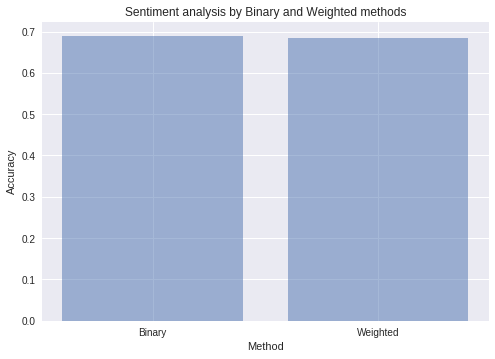

In [10]:

method = ('Binary', 'Weighted')
y_pos = np.arange(len(method))
performance = [token_accuracy, magnitude_accuracy]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, method)
plt.ylabel('Accuracy')
plt.xlabel('Method')
plt.title('Sentiment analysis by Binary and Weighted methods')
 
plt.show()


Answering questions in statistically significant ways (1pt)
-------------------------------------------------------------

Does using the magnitude improve the results? Oftentimes, answering questions like this about the performance of
different signals and/or algorithms by simply looking at the output
numbers is not enough. When dealing with natural language or human
ratings, it’s safe to assume that there are infinitely many possible
instances that could be used for training and testing, of which the ones
we actually train and test on are a tiny sample. Thus, it is possible
that observed differences in the reported performance are really just
noise. 

There exist statistical methods which can be used to check for
consistency (*statistical significance*) in the results, and one of the
simplest such tests is the **sign test**. 

The sign test is based on the binomial distribution. Count all cases when System 1 is better than System 2, when System 2 is better than System 1, and when they are the same. Call these numbers $Plus$, $Minus$ and $Null$ respectively. 

The sign test returns the probability that the null hypothesis is true. 

This probability is called the $p$-value and it can be calculated for the two-sided sign test using the following formula (we multiply by two because this is a two-sided sign test and tests for the significance of differences in either direction):

$$2 \, \sum\limits_{i=0}^{k} \binom{N}{i} \, q^i \, (1-q)^{N-i}$$

where $$N = 2 \Big\lceil \frac{Null}{2}\Big\rceil + Plus + Minus$$ is the total
number of cases, and
$$k = \Big\lceil \frac{Null}{2}\Big\rceil + \min\{Plus,Minus\}$$ is the number of
cases with the less common sign. 

In this experiment, $q = 0.5$. Here, we
treat ties by adding half a point to either side, rounding up to the
nearest integer if necessary. 


#### (Q 2.1): Implement the sign test. Is the difference between the two symbolic systems significant? What is the p-value? (1 pt)

You should use the `comb` function from `scipy` and the `decimal` package for the stable adding of numbers in the final summation.

You can quickly verify the correctness of
your sign test code using a [free online
tool](https://www.graphpad.com/quickcalcs/binomial1.cfm).

In [11]:
from decimal import *
import scipy



def sign_test(results_1, results_2):
  """test for significance
  results_1 is a list of classification results (+ for correct, - incorrect)
  results_2 is a list of classification results (+ for correct, - incorrect)
  """
  ties, plus, minus = 0, 0, 0
  q=0.5
  
  # "-" carries the error
  for i in range(0, len(results_1)):
    if results_1[i] == results_2[i]:
      ties += 1
    elif results_1[i] == 0: 
      plus += 1
    elif results_2[i] == 0: 
      minus += 1

  n = 2*math.ceil(ties/2)+plus+minus
  k = math.ceil(ties/2)+min(plus,minus)

  summation = Decimal(0.0)
  for i in range(0,int(k)+1):
      summation += Decimal(scipy.special.comb(n,i,exact=True))
  
  # use two-tailed version of test
  summation *= 2
  summation *= (Decimal(q)**Decimal(n))
  
  print("the difference is", 
        "not significant" if summation >= 0.05 else "significant")
  
  return summation

p_value = sign_test(token_results, magnitude_results)
print("p_value =", p_value)

the difference is not significant
p_value = 0.8756244234337031344389177957


## Using the Sign test

**From now on, report all differences between systems using the
sign test.** You can think about a change that you apply to one system, as a
 new system.
    
You should report statistical test
results in an appropriate form – if there are several different methods
(i.e., systems) to compare, tests can only be applied to pairs of them
at a time. This creates a triangular matrix of test results in the
general case. When reporting these pair-wise differences, you should
summarise trends to avoid redundancy.


Naive Bayes (8pt + 1pt bonus)
==========


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described in Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing text information as vectors (or points in space), making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text.

## Writing your own classifier

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you a position to replicate
    Pang et al., Naive Bayes results. However, the numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. You will find the
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, and store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.

#### (Q3.1) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining reviews cv900–cv999.  Report results using simple classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


**DESIGN CHOICE**: There are some words that occur in texts related to one class and not the other. These words are added to the vocabulary and will hava a count of zero for the class they don't appear in. As a result, they will have a zero probability which would lead to a $-\infty$ log probability. in order to remedy this, we replace each zero probability with a number greater than one. Here we are using $e$. Since the other probabilities will be less than one, and therefore have a negative $log$, the only positive log probabilities will be the ones that had a zero count. This makes them easy to detect. Later, in the testing phase, the log probabilities are only added in the calculation if they are negative.

In [12]:
# Implementation of Naive Bayes Classifier


t_size = int(.9*len(reviews)) #training size
negative_size = int(t_size/2)
train_set_i = [] # stores indexes of the training set
for i in range(0, negative_size): # indexes of the negative reviews
  train_set_i.append(i)
for i in range(int(len(reviews)/2), len(reviews) - 100): # indexes of the positive reviews
  train_set_i.append(i)


def init_dict(reviews):
  w_dict = {} #count the number of times each word appears in each class 
  for r in range(len(reviews)):
    # loops through all reviews and add the words to the dict word_frequency.
    for sentence in reviews[r]["content"]: 
      for word, pos_tag in sentence:
        word = word.lower()
        w_dict[word] = [0, 0]  # [NEGATIVE, POSITIVE]
  return w_dict
        
def count(reviews, index):
  ''' counts the presence in the set of pos and neg reviews
  returns:
    word_frequency: a dictionary, consisting of the number of times EACH word 
    happened in each class
    vocab _frequency: a vector, consisting of the totall times ALL the words 
    were used in each class
  '''
  
  word_frequency = init_dict(reviews)
  review_class = 0
  for r in index:
    if (reviews[r]["sentiment"] == 'NEG'):
      review_class = 0
    else:
      review_class = 1
    for sentence in reviews[r]["content"]:
      for word, pos_tag in sentence:
        word = word.lower()
        word_frequency[word][review_class] += 1

  vocab_frequency = [0, 0] # stores the total times all the words used in each class
  vocab_frequency = np.sum(list(word_frequency.values()), axis=0)
      
  return vocab_frequency, word_frequency

def log_probabilities(prob_class, word_frequency, prob_word_given_class, w_dic):
  # spaceship to the log-space:
  ln_p_class = [np.log(prob_class[0]), np.log(prob_class[1])] 
  ln_p_word_g_class = w_dic
  for word in word_frequency:
    # work around words that do not happen in one of the classes.
    # We avoind taking the log of zero by replacing it by a number higher than 1,
    # we use the natural constant e such that ln(e) = 1 > ln (0<x<1) < 0
    # This approach requires the classifier to filter out all log probabiliter 
    # higher than zero.
    if (prob_word_given_class[word][0] <= 0):
      pwgc_n = np.e
    else:
      pwgc_n = prob_word_given_class[word][0]
    if (prob_word_given_class[word][1] <= 0):
      pwgc_p = np.e
    else:
      # In the case of the word being present in that class, it just takes the 
      # natural logarithm as it is suposed to do.
      pwgc_p = prob_word_given_class[word][1]
    ln_p_word_g_class[word] = [np.log(pwgc_n),
                               np.log(pwgc_p)]
  return ln_p_class, ln_p_word_g_class

def class_probability(index, negative_size):
  # returns the probability of each class in the training set
  prob_class  = [negative_size/len(index), 1-negative_size/len(index)]
  return prob_class

def word_probability(w_dic, vocab_frequency, word_frequency):
  # returns the probability of each word given the class, for each class
  prob_word_given_class = w_dic
  for word in word_frequency:
    for i in range (2):
      prob_word_given_class[word][i] = word_frequency[word][i]/vocab_frequency[i]
      
  return prob_word_given_class

def training(index, reviews, negative_size, vocab_frequency, word_frequency):
  # trains the NB_classifier
  w_dic=init_dict(reviews)
  prob_word_given_class = word_probability(w_dic,
                                           vocab_frequency, 
                                           word_frequency)
  
  prob_class = class_probability(index, negative_size)

  ln_p_class, ln_p_word_g_class = log_probabilities(prob_class,
                                                    word_frequency,
                                                    prob_word_given_class,
                                                    w_dic)
  return  ln_p_class, ln_p_word_g_class


# Train the Naive Bayes Classifier:
vocab_frequency, word_frequency = count(reviews,
                                        train_set_i)

ln_p_class, ln_p_word_g_class = training(train_set_i,
                                             reviews,
                                             negative_size, 
                                             vocab_frequency,
                                             word_frequency)

# Test the NB-Classifier
test_set_i = [] # stores indexes of the test set
for i in range(int(t_size/2),int(len(reviews)/2)): # indexes of the negative reviews
  test_set_i.append(i)
for i in range(len(reviews) - 100, len(reviews)): # indexes of the positive reviews
  test_set_i.append(i)
  
def classify(ln_p_class, ln_p_word_g_class, test_set_i, reviews):
  # ^c = argmax [ln(prob_class(c) + sum(prob_word_in_class)]
  NB_classifier = []
  for r in test_set_i:
    n_or_p = [ln_p_class[0] , ln_p_class[1]]
    for sentence in reviews[r]["content"]: 
      for word, pos_tag in sentence:
        word = word.lower()
        # checks if word was used in the negative class
        if ln_p_word_g_class[word][0] < 0: 
          n_or_p[0] += ln_p_word_g_class[word][0]
        # checks if word was used in the positive class
        if ln_p_word_g_class[word][1] < 0: 
          n_or_p[1] += ln_p_word_g_class[word][1]
    if (n_or_p[0] >= n_or_p[1]):
      NB_classifier.append([0,r]) # classified as negative 
    else: 
      NB_classifier.append([1,r]) # classified as positive
  return NB_classifier


def evaluate_NB_classifier(NB_classifier, test_set_i, reviews):
  NB_results = [] # 1 -> correctly evaluated, 0 -> falsely evaluated
  review_sentiment = []
  for i in range(len(test_set_i)):
  #for i in test_set_i:
    r = NB_classifier[i][1] # r stores the index of the review 
    review_sentiment.append(reviews[r]["sentiment"])
    if (reviews[r]["sentiment"] == "NEG" and NB_classifier[i][0] == 0):
      NB_results.append(1)
    elif (reviews[r]["sentiment"] == "POS" and NB_classifier[i][0] == 1):
      NB_results.append(1)
    else:
      NB_results.append(0)
  return NB_results

#Test the Naive Bayes Classifier:
NB_classifier = classify(ln_p_class,
                         ln_p_word_g_class,
                         test_set_i,
                         reviews)
#print(NB_classifier)
results_without_smoothing = evaluate_NB_classifier(NB_classifier, 
                                                   test_set_i, 
                                                   reviews)
#print(results_without_smoothing)
NB_normal = sum(results_without_smoothing)/len(results_without_smoothing)
print("accuracy: ", sum(results_without_smoothing)/len(results_without_smoothing))

accuracy:  0.495


As can be seen, Naive Bayse without smoothing is about as bad as a random classifier! Part of it is due to how it handles unseen words - it ignores them. This problem becomes very evident in the following seciton where we deal with a unballanced dataset.

#### (Bonus Questions) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

You can simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In [13]:
negative_size = 90
negative_training_start = 0
negative_training_end = negative_size
prositive_training_start = int(len(reviews)/2)
positive_training_end = len(reviews) - 100

train_set_i = [] # stores indexes of the training set
# indexes of the negative reviews
for i in range(negative_training_start , negative_training_end): 
  train_set_i.append(i)
# indexes of the positive reviews
for i in range(prositive_training_start, positive_training_end): 
  train_set_i.append(i)

negative_test_start = negative_training_end
negative_test_end = int(negative_training_end +.1*negative_size)
positive_test_start = positive_training_end
positive_test_end = len(reviews)

test_set_i = [] # stores indexes of the training set
# indexes of the negative reviews
for i in range(negative_test_start, negative_test_end): 
  test_set_i.append(i)
  
# indexes of the positive reviews
for i in range(positive_test_start, positive_test_end): 
  test_set_i.append(i)
  
# Train the Naive Bayes Classifier:  
vocab_frequency, word_frequency = count(reviews,
                                        train_set_i)

ln_p_class, ln_p_word_g_class = training(train_set_i,
                                             reviews,
                                             negative_size, 
                                             vocab_frequency,
                                             word_frequency)

print(" Positive bias:", np.exp(ln_p_class[1]), 
      "\n Negative bias:", np.exp(ln_p_class[0]))

# Test the Naive Bayes Classifier:
NB_classifier = classify(ln_p_class,
                         ln_p_word_g_class,
                         test_set_i,
                         reviews)

results_uneven = evaluate_NB_classifier(NB_classifier, 
                                        test_set_i, 
                                        reviews)
print("acuracy: ", sum(results_uneven)/len(results_uneven))

 Positive bias: 0.9090909090909091 
 Negative bias: 0.0909090909090909
acuracy:  0.08256880733944955


**(Bonus Question)** Discussion of the results: \\
The Naive Bayes classifier does about as good as randomly classifying reviews as *positive* or *negative*. Which means that this approach is about as bad as tossing a coin. The classification is done by:

$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

For Q3.1 the reviews are balanced, which means that $P(c = negative ) = P(c = positive) = 0.5 $ . The classification is done purelly on the words in each review. However, most words are nouns, conectives and verbs without a particular conotation indepented of cotext. A large part of this sum $\sum^n_{i=1} \log P(f_i|c) $ consists of words that are not relevant for the sentiment classification. \\

For the Bonus Question, 90% of our training data and 90% of our test data consists of positive reviews. A classifier that classifies all test data as positive would perform 90% accurate already! For the Naive Bayes Classifier $P(c = positive ) = 9P(c = negative) = 0.9 $, we would expect the classifier has a quite large bias towards positive reviews. Yet, its performance is lower than 9%. \\

That is due to how to the sum part of the formula: $\sum^n_{i=1} \log P(f_i|c) $ and to a detail of the implementation. We are suming the logs of numbers between zero and 1. We are then summing negative numbers. However when a word wasn't seen in a class, it just ignores it. Which means that we are summing $0 > log(0<x<1)$. As the classifier was trained with much more positive words than negative words, during the classification it has to ignore a lot of unseen negative words. From our results, this happens in such a scale that is enough to overcome the large positive bias.



## Smoothing

The presence of words in the test dataset that
haven’t been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q3.2) Implement Laplace feature smoothing (1pt)
($smoothing(\cdot) = \kappa$, constant for all words) in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [14]:
kappa=1

def smoothing(vocab_frequency,word_frequency):
  for word in word_frequency:
    for i in range(len(word_frequency[word])):
      word_frequency[word][i] += kappa

  for i in range(len(vocab_frequency)):
    vocab_frequency[i] += len(word_frequency)*kappa
  return vocab_frequency,word_frequency 

#making the train indices
t_size = int(.9*len(reviews)) #training size
negative_size = int(t_size/2)
train_set_i = [] # stores indexes of the training set
for i in range(0, negative_size): # indexes of the negative reviews
  train_set_i.append(i)
for i in range(int(len(reviews)/2), len(reviews) - 100): # indexes of the positive reviews
  train_set_i.append(i)
  
#making the test indices
test_set_i = [] # stores indexes of the test set
for i in range(int(t_size/2),int(len(reviews)/2)): # indexes of the negative reviews
  test_set_i.append(i)
for i in range(len(reviews) - 100, len(reviews)): # indexes of the positive reviews
  test_set_i.append(i)

#adding smoothing
vocab_frequency, word_frequency = count(reviews,
                                        train_set_i)

vocab_frequency,word_frequency= smoothing(vocab_frequency,word_frequency)

#training with the smoothed frequencies
ln_p_class, ln_p_word_g_class = training(train_set_i, 
                                         reviews,
                                         negative_size, 
                                         vocab_frequency, 
                                         word_frequency)

#classifying 
NB_classifier = classify(ln_p_class,
                         ln_p_word_g_class,
                         test_set_i,
                         reviews)

#evaluating
results_with_smoothing = evaluate_NB_classifier(NB_classifier, 
                                                   test_set_i, 
                                                   reviews)
print("acuracy: ", sum(results_with_smoothing)/len(results_with_smoothing))


acuracy:  0.825


We can see a very large step improvement by just using a simple smoothing technique. This shows once again how much the unseen words were affecting the results of our classifier before. Smoothing is successful in remedying this situation.

#### (Q3.3) Is the difference between non smoothed (Q3.1) and smoothed (Q3.2) statistically significant? (0.5pt)

In [15]:
p_value = sign_test(results_without_smoothing, results_with_smoothing)
print("p_value =", p_value)

the difference is significant
p_value = 0.000003547178174130642586494974890


## Cross-validation

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is that we
end up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that’s better
and better on our data, but worse and worse at generalizing to new,
never-before seen data.

A simple method to guard against Type III errors is to use
cross-validation. In N-fold cross-validation, we divide the data into N
distinct chunks / folds. Then, we repeat the experiment N times, each
time holding out one of the chunks for testing, training our classifier
on the remaining N - 1 data chunks, and reporting performance on the
held-out chunk. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)

#### (Q3.4) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q3.2 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)






In [16]:

def round_robin_split(reviews, mod = 10): 
  ''' return a matrix with wich line the indexes of the reviews for this split.
  '''
  splits = []
  for s in range(mod):
    splits.append([])
    for i in range(s, len(reviews), mod):
      splits[s].append(i)
  return splits

def nr_negative (reviews, splits): 
  ''' return a vector with the number of negative reviews per split.
    by using round_robin_split 10 we get 100 negative reviews per split.
  '''
  negative_size = []
  for split in range(len(splits)): 
    negative_size.append([])
    negative_size[split] = 0
    for review_i in splits[split]:
      if reviews[review_i]['sentiment'] == 'NEG': 
        negative_size[split] += 1
  return negative_size



def train_test_sets(splits, m, negative_sizes): 
  ''' creates the test set and the training set.
  returns:
    train_set_i    indexes of the training set
    test_set_i     indexes of the test set
    negative_size  number of negative revies in the training set
  '''
  train_set_i = []
  negative_size = 0
  for i in range(mod):
    if i == m :
      test_set_i = splits[i]
    else:
      train_set_i += splits[i]
      negative_size +=  negative_sizes[i]
  return train_set_i, test_set_i, negative_size

mod = 10
splits = round_robin_split(reviews, mod = 10)
negative_sizes = nr_negative (reviews, splits)

# Train the Naive Bayes Classifier:  
results_split = []
for m in range(mod): 
  
  
  train_set_i, test_set_i, negative_size = train_test_sets(splits, 
                                                           m, 
                                                           negative_sizes)
  # Train the Naive Bayes Classifier:
  vocab_frequency, word_frequency = count(reviews,
                                          train_set_i) 
    
  smooth_switch = True
  if smooth_switch:
    vocab_frequency, word_frequency = smoothing(vocab_frequency,
                                                word_frequency)

  ln_p_class, ln_p_word_g_class = training(train_set_i,
                                           reviews,
                                           negative_size, 
                                           vocab_frequency,
                                           word_frequency)
  # Test the Naive Bayes Classifier:
  NB_classifier = classify(ln_p_class,
                           ln_p_word_g_class,
                           test_set_i,
                           reviews)

  results_split.append(evaluate_NB_classifier(NB_classifier, 
                                          test_set_i, 
                                          reviews))
  print(m,") acuracy: ", sum(results_split[m])/len(results_split[m]))

  
def report_fold_performance(results_split, print_performance = False):
  fold_performance = [sum(results_split[m])/len(results_split[m]) for m in range(len(results_split))]

  mean_performance = np.mean(fold_performance)
  var_performance = np.var(fold_performance)

  if print_performance:
    print("Mean performance: ", mean_performance, 
          "\n Variance:", var_performance)
    
  return mean_performance, var_performance
_ = report_fold_performance(results_split, print_performance = True)


0 ) acuracy:  0.79
1 ) acuracy:  0.835
2 ) acuracy:  0.81
3 ) acuracy:  0.83
4 ) acuracy:  0.775
5 ) acuracy:  0.845
6 ) acuracy:  0.83
7 ) acuracy:  0.785
8 ) acuracy:  0.825
9 ) acuracy:  0.845
Mean performance:  0.817 
 Variance: 0.0005859999999999986


#### (Q3.5) Write code to calculate and report variance, in addition to the final performance. (1pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [17]:
smoothed_NB = report_fold_performance(results_split, print_performance = True)

Mean performance:  0.817 
 Variance: 0.0005859999999999986


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

#### (Q3.6): A touch of linguistics (1pt)

Taking a step further, you can use stemming to
hash different inflections of a word to the same feature in the BoW
vector space. How does the performance of your classifier change when
you use stemming on your training and test datasets? Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.
 Also, you should do cross validation and concatenate the predictions from all folds to compute the significance.

In [18]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
  
def stem_reviews(stemmed_reviews):
  for r in  range(len(stemmed_reviews)):
    stemmed_sentences = []
    for sentence in stemmed_reviews[r]["content"]:
      stemmed_sentence = []
      for word, pos_tag in sentence:
        word = word.lower()
        word = stemmer.stem(word)
        stemmed_sentence.append([word, pos_tag])
      stemmed_sentences.append(stemmed_sentence)
    stemmed_reviews[r]["content"] = stemmed_sentences
  return stemmed_reviews

def init_dict_with_stemming(reviews):
  w_dict = {} 
  for r in range(len(reviews)):
    # loops through all reviews and add the words to w_dict.
    for sentence in reviews[r]["content"]: 
      for word, pos_tag in sentence:
        word = word.lower()
        word = stemmer.stem(word)
        w_dict[str(word)] = [0, 0]  # [NEGATIVE, POSITIVE]
  return w_dict


#cross-validation
mod=10
results_with_stemming = []
splits = round_robin_split(reviews, mod = 10)
negative_sizes = nr_negative (reviews, splits)

debug = True
  
with open("reviews.json", mode="r", encoding="utf-8") as f:
  stemmed_reviews = json.load(f)

# Just stem the complete review once and use the standard functions created before!
if debug:
    print("stemming reviews in progress ...")
stemmed_reviews = stem_reviews(stemmed_reviews) 


for m in range(mod): 
  train_set_i, test_set_i, negative_size = train_test_sets(splits, 
                                                         m, 
                                                         negative_sizes)
  # Train the Naive Bayes Classifier:
  vocab_frequency, word_frequency = count(stemmed_reviews,
                                          train_set_i) 

  smooth_switch = True
  if smooth_switch:
    vocab_frequency, word_frequency = smoothing(vocab_frequency,
                                                word_frequency)

  ln_p_class, ln_p_word_g_class = training(train_set_i,
                                           stemmed_reviews,
                                           negative_size, 
                                           vocab_frequency,
                                           word_frequency)
  # Test the Naive Bayes Classifier:
  NB_classifier = classify(ln_p_class,
                           ln_p_word_g_class,
                           test_set_i,
                           stemmed_reviews)

  results_with_stemming.append(evaluate_NB_classifier(NB_classifier, 
                                                      test_set_i, 
                                                      stemmed_reviews))

  print(m,") acuracy: ", 
        sum(results_with_stemming[m])/len(results_with_stemming[m]))
  

stem_NB = report_fold_performance(results_with_stemming, print_performance = True)
                                                   


stemming reviews in progress ...
0 ) acuracy:  0.78
1 ) acuracy:  0.84
2 ) acuracy:  0.81
3 ) acuracy:  0.85
4 ) acuracy:  0.775
5 ) acuracy:  0.835
6 ) acuracy:  0.815
7 ) acuracy:  0.775
8 ) acuracy:  0.83
9 ) acuracy:  0.84
Mean performance:  0.8150000000000001 
 Variance: 0.0007549999999999986


#### (Q3.7): Is the difference between NB with smoothing and NB with smoothing+stemming significant? (0.5pt)


In [19]:
#append all folds in one single vector.
all_split_results = []
all_stem_results = []
for m in range(len(results_split)):
  all_split_results += results_split[m]
  all_stem_results += results_with_stemming[m]
  
p_value = sign_test(all_split_results, all_stem_results)

print("p_value =", p_value)

the difference is not significant
p_value = 0.9465186089423488346539016590


The results show that adding stemming does not improve the results significantly. One possible reason coul be because the stemmer is not always correct in finding words with similiar stems, and count words with different meanings and maybe even different sentiments as one word. However we supose this would only play a marginal role. 
However, in both cases a large number of words in the review carry no relenvant meaning for the sentment analisys. Stemming them does not filter them out and our Naive Bayes Classifier is as confused as before when classifing some reviews.

#### Q3.8: What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q3.2)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [20]:
review=[]
for i in range(0,900):
  review.append(reviews[i])
for i in range(1000,1900):
  review.append(reviews[i])
print('Stemming in progress.')
vocab_with_stemming = init_dict_with_stemming(review)
vocab_without_stemming = init_dict(review)
print("Size of The Vocabulary Before Stemming:   ",len(vocab_without_stemming))
print("Size of The Vocabulary After Stemming:   ",len(vocab_with_stemming))



Stemming in progress.
Size of The Vocabulary Before Stemming:    45348
Size of The Vocabulary After Stemming:    32404


It can be seen that stemming has successfuly reduced the number of features by 28%. Which could be interesting when analising larger datasets.

#### Q3.9: Putting some word order back in (0.5+0.5pt=1pt)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-grams** features. 
Retrain your classifier from (Q3.4) using **unigrams+bigrams** and
**unigrams+bigrams+trigrams** as features, and report accuracy and statistical significances (in comparison to the experiment at (Q3.4) for all 10 folds, and between the new systems).





**DESIGN CHOICE:**
When going through the reviews, we count the ending character of each sentence and the begining of the next sentence as a n-gram. Thus we are considering our sentences to be related in a review.

In [0]:
##necessary functions

def init_dict_ngram(reviews):
  #makes a dictionary of unigrams, a dictionary of bigrams and a dictionary of trigrams
  w_dict = {} #count the number of times each word appears in each class 
  bigram_dict={}
  trigram_dict={}
  for r in range(len(reviews)):
    word = ['', '', '']             # word = [word, prev word, prev prev word]
    count = 0
    p = count
    for sentence in reviews[r]["content"]: 
      for word[p], pos_tag in sentence:
        word[p] = word[p].lower()
        w_dict[word[p]] = [0, 0]          # [NEGATIVE class, POSITIVE class]
        bigram = str(word[p-1] + word[p]) # prev_word + word
        bigram_dict[bigram] = [0, 0]      # [NEGATIVE class, POSITIVE class]
        trigram = str(word[p-2] + bigram) # prev_prev_word + prev_word + word
        trigram_dict[trigram] = [0, 0]    # [NEGATIVE class, POSITIVE class]
        count += 1
        p = count%3
  return w_dict, bigram_dict, trigram_dict


def count_ngram(reviews, index):
  #takes a set of reviews, makes ngrams, and counts unigrams and ngrams. 
  #'ngram'_frequency: dictionary with the count of each word
  #'ngram'V_frequency: stores the total times all the 'ngrams' were used in each class
  
  word_frequency, bigram_frequency ,trigram_frequency = init_dict_ngram(reviews)
  review_class = 0
  #counting loop, storing in each 'ngram'_frequency
  for r in index:
    count=0
    if (reviews[r]["sentiment"] == 'NEG'):
      review_class = 0
    else:
      review_class = 1
    for sentence in reviews[r]["content"]:
      for word, pos_tag in sentence:
        word = word.lower()
        word_frequency[word][review_class] += 1
        if count >=2:
          Ngram=str(prev_word+word)
          bigram_frequency[Ngram][review_class] += 1
          Ngram=str(prev_prev_word+prev_word+word)
          trigram_frequency[Ngram][review_class] += 1
          prev_prev_word=prev_word
        elif count == 1:
          Ngram=str(prev_word+word)
          bigram_frequency[Ngram][review_class] += 1
          prev_prev_word=prev_word
        count +=1
        prev_word=word      
  
  #summing the counts, making 'ngram'V_frequencies
  vocab_frequency = [0, 0] #vocab frequency:stores the total times all the words used in each class
  biV_frequency=[0,0]      #bigram vocab frequency
  triV_frequency=[0,0]     #trigram vocab frequency
  for word in word_frequency: 
    vocab_frequency[0] += word_frequency[word][0] #negative class
    vocab_frequency[1] += word_frequency[word][1] #positive class
  for ngram in bigram_frequency:
    biV_frequency[0] += bigram_frequency[ngram][0] #negative class
    biV_frequency[1] += bigram_frequency[ngram][1] #positive class
  for ngram in trigram_frequency:
    triV_frequency[0] += trigram_frequency[ngram][0] #negative class
    triV_frequency[1] += trigram_frequency[ngram][1] #positive class
      
  return vocab_frequency, word_frequency,biV_frequency,bigram_frequency, triV_frequency,trigram_frequency


def training_ngram(w_dic,index, reviews, negative_size, vocab_frequency, word_frequency):
  # trains the NB_classifier
  prob_word_given_class = word_probability(w_dic,
                                           vocab_frequency, 
                                           word_frequency)
  
  prob_class = class_probability(index, negative_size)

  ln_p_class, ln_p_word_g_class = log_probabilities(prob_class,
                                                    word_frequency,
                                                    prob_word_given_class,
                                                    w_dic)
  return  ln_p_class, ln_p_word_g_class

def classify_ngram(num_ngram,ln_p_class, ln_p_word_g_class,ln_p_bigram_g_class,ln_p_trigram_g_class, test_set_i, reviews):
  # ^c = argmax [ln(prob_class(c) + sum(prob_word_in_class)]
  
  #switches, deciding what degree of ngrams is being considered
  if num_ngram == 0:
    bigram_switch = False
    trigram_switch = False
  if num_ngram == 1:
    bigram_switch = True
    trigram_switch = False
  if num_ngram == 2:
    bigram_switch = True
    trigram_switch = True
  
  #looping over the test reviews, counting over each dictionary and calculating the overall probabilities
  NB_classifier = []
  for r in test_set_i:
    count=0
    n_or_p = [ln_p_class[0] , ln_p_class[1]]
    for sentence in reviews[r]["content"]: 
      for word, pos_tag in sentence:
        word = word.lower()
        #checks if word is in the negative class
        if ln_p_word_g_class[word][0] < 0: 
          n_or_p[0] += ln_p_word_g_class[word][0]
        #checks if word was used in the positive class
        if ln_p_word_g_class[word][1] < 0: 
          n_or_p[1] += ln_p_word_g_class[word][1]
        
        if bigram_switch:
          if count>=1:
            Ngram=str(prev_word_b+word)
            #checks if bigram is in the negative class
            if ln_p_bigram_g_class[Ngram][0] < .5: 
               n_or_p[0] += ln_p_bigram_g_class[Ngram][0]
            #checks if bigram was used in the positive class
            if ln_p_bigram_g_class[Ngram][1] < .5: 
               n_or_p[1] += ln_p_bigram_g_class[Ngram][1]
            #update
            prev_word_b=word
          else:
            prev_word_b=word
           
        if trigram_switch:
          if count>=2:
            Ngram=str(prev_prev_word+prev_word+word)
            #checks if trigram is in the negative class
            if ln_p_trigram_g_class[Ngram][0] < .5: 
               n_or_p[0] += ln_p_trigram_g_class[Ngram][0]
            #checks if trigram was used in the positive class
            if ln_p_trigram_g_class[Ngram][1] < .5: 
               n_or_p[1] += ln_p_trigram_g_class[Ngram][1]
            #update
            prev_prev_word=prev_word
            prev_word=word
          if count==0:
            prev_word=word
          if count==1:
            prev_prev_word=prev_word
            prev_word=word
        count +=1  
       
    if (n_or_p[0] >= n_or_p[1]):
      NB_classifier.append([0,r]) # classified as negative
    else: 
      NB_classifier.append([1,r]) # classified as positive
  return NB_classifier

 
def cross_validation_ngram(num_ngram):
  #cross validation
  mod=10
  results_ngram = []
  splits = round_robin_split(reviews, mod = 10)
  negative_sizes = nr_negative (reviews, splits)

  for m in range(mod):
    #Training
    train_set_i, test_set_i, negative_size = train_test_sets(splits,
                                                             m,
                                                             negative_sizes)

    vocab_frequency, word_frequency, biV_frequency, bigram_frequency, triV_frequency, trigram_frequency = count_ngram(reviews, train_set_i)

    smooth_switch = True
    if smooth_switch:
      vocab_frequency, word_frequency = smoothing(vocab_frequency,
                                                  word_frequency)
      biV_frequency, bigram_frequency = smoothing(biV_frequency,
                                                  bigram_frequency)
      triV_frequency, trigram_frequency = smoothing(triV_frequency,
                                                  trigram_frequency)

    w_dict, bigram_dict, trigram_dict = init_dict_ngram(reviews)
    
    #calculating log probabilities 
    if num_ngram == 0 or num_ngram == 1 or num_ngram == 2:    #for single words
      ln_p_class, ln_p_word_g_class = training_ngram(w_dict,train_set_i,
                                                     reviews,
                                                     negative_size, 
                                                     vocab_frequency,
                                                     word_frequency)
    if num_ngram == 1 or num_ngram == 2:           #for a sequence of two words
      ln_p_class, ln_p_bigram_g_class = training_ngram(bigram_dict,train_set_i,
                                                     reviews,
                                                     negative_size, 
                                                     biV_frequency,
                                                     bigram_frequency)
    if num_ngram == 2:        #for a sequence of 3 words
      ln_p_class, ln_p_trigram_g_class = training_ngram(trigram_dict,train_set_i,
                                                     reviews,
                                                     negative_size, 
                                                     triV_frequency,
                                                     trigram_frequency)
    
    if num_ngram !=2:      #to avoid referencing them in the NB_classifier function without initialization
      ln_p_trigram_g_class=[]
    if num_ngram==0:
      ln_p_bigram_g_class=[]
      
    #Test Classifier:
    NB_classifier = classify_ngram(num_ngram,ln_p_class,
                             ln_p_word_g_class,
                             ln_p_bigram_g_class,
                             ln_p_trigram_g_class,
                             test_set_i,
                             reviews)
    #print(NB_classifier)
    results_ngram.append(evaluate_NB_classifier(NB_classifier, 
                                                       test_set_i, 
                                                       reviews))

    print(m,") acuracy: ", 
          sum(results_ngram[m])/len(results_ngram[m]))
    
  return results_ngram,w_dict, bigram_dict, trigram_dict
  
  

In [22]:
##calculating the results

print("Using bigrams + unigrams:")
results_bigram,w_dict, bigram_dict, trigram_dict = cross_validation_ngram(1)
bigrams_NB = report_fold_performance(results_bigram, print_performance = True)

print("Using trigrams + bigrams + unigrams:")
results_trigram,w_dict, bigram_dict, trigram_dict = cross_validation_ngram(2)
trigrams_NB = report_fold_performance(results_trigram, print_performance = True)

#add mean and variance for each one
#print what which one is doing

Using bigrams + unigrams:
0 ) acuracy:  0.795
1 ) acuracy:  0.87
2 ) acuracy:  0.835
3 ) acuracy:  0.88
4 ) acuracy:  0.805
5 ) acuracy:  0.865
6 ) acuracy:  0.835
7 ) acuracy:  0.83
8 ) acuracy:  0.855
9 ) acuracy:  0.84
Mean performance:  0.841 
 Variance: 0.0006739999999999994
Using trigrams + bigrams + unigrams:
0 ) acuracy:  0.795
1 ) acuracy:  0.89
2 ) acuracy:  0.855
3 ) acuracy:  0.865
4 ) acuracy:  0.795
5 ) acuracy:  0.89
6 ) acuracy:  0.835
7 ) acuracy:  0.835
8 ) acuracy:  0.875
9 ) acuracy:  0.845
Mean performance:  0.8480000000000001 
 Variance: 0.0010559999999999996


In [23]:
##calculating p-values

#append all folds in one single vector.
all_split_results = []
all_bigram_results = []
all_trigram_results = []
for m in range(len(results_split)):
  all_split_results += results_split[m]
  all_bigram_results += results_bigram[m]
  all_trigram_results += results_trigram[m]

print("NB using only unigrams and NB using unigrams+bigrams:")
p_value_bigram_split = sign_test(all_split_results, all_bigram_results)
print("p_value =", p_value_bigram_split)
print("")

print("NB using only unigrams and NB using unigrams+bigrams + trigrams:")
p_value_trigram_split = sign_test(all_split_results, all_trigram_results)
print("p_value =", p_value_trigram_split)
print("")

print("NB using unigrams+bigrams and NB using unigrams+bigrams + trigrams:")
p_value_trigram_bigram_split = sign_test(all_bigram_results, all_trigram_results)
print("p_value =", p_value_trigram_bigram_split)
print("")

NB using only unigrams and NB using unigrams+bigrams:
the difference is not significant
p_value = 0.2932785698870256137209886960

NB using only unigrams and NB using unigrams+bigrams + trigrams:
the difference is not significant
p_value = 0.1725517183477154341914779742

NB using unigrams+bigrams and NB using unigrams+bigrams + trigrams:
the difference is not significant
p_value = 0.7712977979137471160722421800




#### Q3.10: How many features does the BoW model have to take into account now? (0.5pt)
How does this number compare (e.g., linear, square, cubed, exponential) to the number of features at (Q3.8)? 

Use the held-out training set once again for this.


In [24]:
review=[]
for i in range(0,900):
  review.append(reviews[i])
for i in range(1000,1900):
  review.append(reviews[i])

vocab_with_stemming = init_dict_with_stemming(review)
vocab_without_stemming=init_dict(review)
#w_dict, bigram_dict, trigram_dict=init_dict_ngram(review)
size_trigram=len(w_dict)+len(bigram_dict)+len(trigram_dict)
size_bigram=len(w_dict)+len(bigram_dict)
print("Size of The Vocabulary Before Stemming:   ",len(vocab_without_stemming))
print("Size of The Vocabulary After Stemming:   ",len(vocab_with_stemming))
print("Size of the Vocabulary For unigrams + bigrams:", size_bigram)
print("Size of the Vocabulary For unigrams + bigrams + trigrams:", size_trigram)


Size of The Vocabulary Before Stemming:    45348
Size of The Vocabulary After Stemming:    32404
Size of the Vocabulary For unigrams + bigrams: 508308
Size of the Vocabulary For unigrams + bigrams + trigrams: 1549499


The size of vocabuary after adding bigrams is approximateley 15 times the size of vocabulary for just unigrams. Also, the size of vocabulary after adding trigrams is in the order of three times the size of vocabulary before adding them (just unigrams and bigrams).


> 
It should be mentioned that if we had a close to infinite corpus, where there are all word combinations. Then, if we consider the number of unigrams to be N, the size of the vocabulary would increase by $N^2$ if we add bigrams, and again, if we add the trigrams, $N^3$. But here, since the size of our review set is small, we cannot see the full effect of adding n-grams on the length of vocabulary. In short we were expecting an exponential relationship between vocabulary size and n-grams. In practice we seem experienced some sort of polinomial increase due to some word combinations never happening in the corpus.

# Support Vector Machines (4pts)


Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM.](http://scikit-learn.org/stable/modules/svm.html) with the default parameters.



#### (Q4.1): Train SVM and compare to Naive Bayes (2pt)

Train an SVM classifier (sklearn.svm.LinearSVC) using your features. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier from (Q3.4) and report the numbers.
Do cross validation and concatenate the predictions from all folds to compute the significance.  Are the results significantly better?



In [25]:
from sklearn import svm
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

def super_bag_of_words(reviews, train_set_i):
  w_dict = {}      
  bigram_dict={}
  trigram_dict={}
  for r in train_set_i:
    word = ['', '', '']             # word = [word, prev word, prev prev word]
    count = 0
    p = count
    for sentence in reviews[r]["content"]: 
      for word[p], pos_tag in sentence:
        word[p] = word[p].lower()
        w_dict[word[p]] = 0               # [NEGATIVE class, POSITIVE class]
        bigram = str(word[p-1] + word[p]) # prev_word + word
        bigram_dict[word[p]] = 0
        bigram_dict[bigram] = 0           # [NEGATIVE class, POSITIVE class]
        trigram = str(word[p-2] + bigram) # prev_prev_word + prev_word + word
        trigram_dict[word[p]] = 0
        trigram_dict[bigram] = 0  
        trigram_dict[trigram] = 0         # [NEGATIVE class, POSITIVE class]
        count += 1
        p = count%3
  for n_dict in [w_dict, bigram_dict, trigram_dict]:
    index = 0
    for word in n_dict:
      n_dict[word] = index
      index += 1
  return  w_dict, bigram_dict, trigram_dict

def make_feature_vector(reviews, w_dict, n):
  feature_vectors = np.zeros((len(reviews), len(w_dict))) 
  for r in range(len(reviews)):
    word = ["","",""]
    count = 0
    p = count
    for sentence in reviews[r]["content"]: 
      for word[p], pos_tag in sentence:
        word[p] = word[p].lower()
        tri_gram= str(word[p-2] + word[p-1] + word[p])
        bi_gram = str(word[p-1] + word[p])
        for w in [word[p], bi_gram, tri_gram]:
          ungly_counter = 0
          if w in w_dict:
            ind = w_dict[w] 
            feature_vectors[r][ind] += 1
            ungly_counter += 1
            # that is necessary to make sure the word won't be added multiple 
            # times for bi-grams and unigrams.
            if ungly_counter >= n:
              break
        count += 1
        p = count%n
  return feature_vectors

def label_my_data(reviews):
  label = np.zeros(len(reviews), dtype= int)
  for r in range(len(reviews)):
    if reviews[r]['sentiment'] == 'POS':
      label[r] = 1
  return label

def evaluate_SVM_classifier(classifier, test_set_i, reviews):
  results = np.zeros(len(test_set_i)) # 1 -> correctly evaluated, 0 -> falsely evaluated
  c = 0
  for i in test_set_i:
    if (reviews[i]["sentiment"] == "NEG" and classifier[c] == 0) or (reviews[i]["sentiment"] == "POS" and classifier[c] == 1):
      results[c] = 1
    c += 1
  return results


def cross_validation_SVM(reviews, label, n):
  # cross validation training of SVM
  mod = 10
  splits = round_robin_split(reviews, mod = 10)
  negative_sizes = nr_negative (reviews, splits)
  results_split_SVM = []

  # fold training:
  for m in range(mod):
    

    train_set_i, test_set_i, negative_size = train_test_sets(splits, 
                                                             m, 
                                                             negative_sizes)
    

    word_dict, bi_dict, tri_dict = super_bag_of_words(reviews, train_set_i)
    all_dicts = [word_dict, bi_dict, tri_dict]
    feature_vectors = make_feature_vector(reviews, all_dicts[n-1], n)
    
    fv = [] # feature vectors used in this fold
    l = []  # labels for this fold
    for i in train_set_i:
      fv.append(feature_vectors[i])
      l.append(label[i])

    # The magical Suport Vector Machine trainer:
    clf = svm.LinearSVC()
    clf.fit(fv, l) 
    
    t_fv = []
    for i in test_set_i:
      t_fv.append(feature_vectors[i])
    
    SVM_classification = clf.predict(t_fv)
    
    results_split_SVM.append(evaluate_SVM_classifier(SVM_classification, 
                                                    test_set_i, 
                                                    reviews))
    
    print(m,") acuracy: ", sum(results_split_SVM[m])/len(results_split_SVM[m]))
  return results_split_SVM

label = label_my_data(reviews)

print("word features")
results_split_SVM = cross_validation_SVM(reviews, label, 1)
SVM_word = report_fold_performance(results_split_SVM, print_performance = True)

#For curiosity reasons:
#print("\n unigrams and bi-grams")
#results_split_SVM_bigrams = cross_validation_SVM(reviews, label, 2)
#_ = report_fold_performance(results_split_SVM_bigrams, print_performance = True)

#print("\n unigrams, bigrams and trigrams")
#results_split_SVM_trigrams = cross_validation_SVM(reviews, label, 3)
#_ = report_fold_performance(results_split_SVM_trigrams, print_performance = True)


word features
0 ) acuracy:  0.81
1 ) acuracy:  0.795
2 ) acuracy:  0.8
3 ) acuracy:  0.84
4 ) acuracy:  0.85
5 ) acuracy:  0.815
6 ) acuracy:  0.845
7 ) acuracy:  0.85
8 ) acuracy:  0.875
9 ) acuracy:  0.84
Mean performance:  0.8320000000000001 
 Variance: 0.0005959999999999991


In [26]:
##calculating p-values

#append all folds in one single vector.
all_results_split_SVM = np.array([])
all_results_split = []
for m in range(len(results_split)):
  all_results_split_SVM = np.concatenate((all_results_split_SVM, results_split_SVM[m]))
  all_results_split += results_split[m]

p_value = sign_test(all_results_split_SVM, all_results_split)
print("Comparison SVM and NB for word features:")
print("p_value =", p_value)


the difference is not significant
Comparison SVM and NB for word features:
p_value = 0.5166977962573607869966679093



We would like to point out that we are comparing the Naive Bayes classifier using word features with the SVM also using word features. The importance fair comparison was stressed by one of the teacher assistents in Piazza. For our disapointment, the difference between NB and SVM is not relevant.

### More linguistics

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you. Try to
replicate what Pang et al. were doing:



####(Q4.2) Replace your features with word+POS features, and report performance with the SVM. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significant? Why?  (1pt)


**DESIGN CHOICE:** We are using tuples (word, POS) as  inputs to the vocabulary.

In [27]:
def super_bag_of_words_POS(reviews, train_set_i):
  '''Creates a bag of words for all the words in the training set.
  Inputs:
    reviews: the reviews in the format given in the exercise
    train_set_i: vector of indexes of the reviews of the trainin set
  Return:
    dictionary of the format {(word,POS tag) : index}
    example {(dog, verb): 1243554, (dog, noun): 33333}
  '''
  w_dict = {} 
  for r in train_set_i:
    for sentence in reviews[r]["content"]: 
      for word, pos_tag in sentence:
        word = word.lower()
        w_dict[(word,pos_tag)] = 0 
  index = 0
  for (word,pos_tag) in w_dict:
    w_dict[(word,pos_tag)] = index
    index += 1
  return w_dict
           
def make_feature_vector_POS(reviews, word_dict):
  feature_vectors = [] 
  for r in range(len(reviews)):
    review_vector = [0]*len(word_dict)
    for sentence in reviews[r]["content"]: 
      for word, pos_tag in sentence:
        word = word.lower()
        if (word,pos_tag) in word_dict:
          ind = word_dict[(word,pos_tag)] 
          review_vector[ind] += 1
    feature_vectors.append(review_vector)
  return feature_vectors   
           
def cross_validation_SVM_POS(reviews, label):
  # cross validation training of SVM
  mod = 10
  splits = round_robin_split(reviews, mod = 10)
  negative_sizes = nr_negative (reviews, splits)
  results_split_SVM = []

  # fold training:
  for m in range(mod):

    train_set_i, test_set_i, negative_size = train_test_sets(splits, 
                                                             m, 
                                                             negative_sizes)
    
    word_dict = super_bag_of_words_POS(reviews, train_set_i)
    
    feature_vectors = make_feature_vector_POS(reviews, word_dict)
    
    
    fv = [] # feature vectors used in this fold
    l = []  # labels for this fold
    for i in train_set_i:
      fv.append(feature_vectors[i])
      l.append(label[i])

    # The magical Suport Vector Machine trainer:
    clf = svm.LinearSVC()
    clf.fit(fv, l) 
    
    t_fv = []
    for i in test_set_i:
      t_fv.append(feature_vectors[i])
    
    SVM_classification = clf.predict(t_fv)

    results_split_SVM.append(evaluate_SVM_classifier(SVM_classification, 
                                                    test_set_i, 
                                                    reviews))

    # 3- check accuracy and compute significance by use of the sign-test

    print(m,") acuracy: ", sum(results_split_SVM[m])/len(results_split_SVM[m]))
  return results_split_SVM

label = label_my_data(reviews)
results_split_SVM_POS = cross_validation_SVM_POS(reviews, label)
SVM_wp = report_fold_performance(results_split_SVM_POS, print_performance = True)


0 ) acuracy:  0.82
1 ) acuracy:  0.795
2 ) acuracy:  0.825
3 ) acuracy:  0.84
4 ) acuracy:  0.84
5 ) acuracy:  0.845
6 ) acuracy:  0.855
7 ) acuracy:  0.855
8 ) acuracy:  0.865
9 ) acuracy:  0.84
Mean performance:  0.8380000000000001 
 Variance: 0.0003709999999999997


In [28]:
#append all folds in one single vector.
all_results_split_SVM_POS = np.array([])
for m in range(len(results_split)):
  all_results_split_SVM_POS = np.concatenate((all_results_split_SVM_POS, 
                                              results_split_SVM_POS[m]))

p_value = sign_test(all_results_split_SVM, all_results_split_SVM_POS)

print("p_value =", p_value)

the difference is not significant
p_value = 0.8057148676803825624105038557


We are comparing two SVMs, one using the word features and the second using the tuples word POS tags as features. However the difference in performance is not significant. Intuitively, that makes sense. The POS tags do not carry any information about the meaning of the word, only about the grammatical role of that word in that sentence. Therefore they do not help to extract the meaning or the sentiment of the word.


#### (Q4.3) Discard all closed-class words from your data (keep only nouns (N*), verbs (V*), adjectives (J*) and adverbs (RB*)), and report performance. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significantly better than when we don't discard the closed-class words? Why? (1pt)

In [29]:
def bag_of_words_POS_without_clossed_class(reviews, train_set_i):
  w_dict = {} #count the number of times each word appears in each class 
  for r in train_set_i:
    # loops through all reviews and add the words to the dict.
    for sentence in reviews[r]["content"]: 
      for word, pos_tag in sentence:
        if pos_tag[0] in 'NVJ' or pos_tag[0:1]=='RB':
          word = word.lower()
          w_dict[(word, pos_tag)] = 0 
  index = 0
  for (word,pos_tag) in w_dict:
    w_dict[(word, pos_tag)] = index
    index += 1
  return w_dict

def make_feature_vector_POS_without_clossed_class(reviews,word_dict):
  feature_vectors = [] # np.zeros([len(reviews),len(word_dict)])
  for r in range(len(reviews)):
    review_vector = [0]*len(word_dict)
    for sentence in reviews[r]["content"]: 
      for word, pos_tag in sentence:
        if pos_tag[0] in 'NVJ' or pos_tag[0:1]=='RB': 
          word = word.lower()
          if (word,pos_tag) in word_dict:
            ind = word_dict[(word,pos_tag)]
            review_vector[ind] += 1
    feature_vectors.append(review_vector)
  return feature_vectors 

def cross_validation_SVM_POS_without_clossed_class(reviews, label):
  # cross validation training of SVM
  mod = 10
  splits = round_robin_split(reviews, mod = 10)
  negative_sizes = nr_negative (reviews, splits)
  results_split_SVM = []

  # fold training:
  for m in range(mod):

    train_set_i, test_set_i, negative_size = train_test_sets(splits, 
                                                             m, 
                                                             negative_sizes)
    
    word_dict = bag_of_words_POS_without_clossed_class(reviews, train_set_i)
    
    feature_vectors = make_feature_vector_POS_without_clossed_class(reviews, 
                                                                    word_dict)
    
    
    fv = [] # feature vectors used in this fold
    l = []  # labels for this fold
    for i in train_set_i:
      fv.append(feature_vectors[i])
      l.append(label[i])

    # The magical Suport Vector Machine trainer:
    clf = svm.LinearSVC()
    clf.fit(fv, l) 
    
    t_fv = []
    for i in test_set_i:
      t_fv.append(feature_vectors[i])
    
    SVM_classification = clf.predict(t_fv)

    results_split_SVM.append(evaluate_SVM_classifier(SVM_classification, 
                                                    test_set_i, 
                                                    reviews))

    # 3- check accuracy and compute significance by use of the sign-test

    print(m,") acuracy: ", sum(results_split_SVM[m])/len(results_split_SVM[m]))
  return results_split_SVM

label = label_my_data(reviews)

results_split_SVM_POS_without_clossed_class = cross_validation_SVM_POS_without_clossed_class(reviews, label)

SVM_sw = report_fold_performance(results_split_SVM_POS_without_clossed_class, print_performance = True)


0 ) acuracy:  0.82
1 ) acuracy:  0.84
2 ) acuracy:  0.81
3 ) acuracy:  0.82
4 ) acuracy:  0.835
5 ) acuracy:  0.86
6 ) acuracy:  0.86
7 ) acuracy:  0.86
8 ) acuracy:  0.87
9 ) acuracy:  0.79
Mean performance:  0.8365 
 Variance: 0.0006202499999999995


In [30]:
##calculating p-values

all_results_split_SVM_POS_without_clossed_class = np.array([])
for m in range(len(results_split)):
  all_results_split_SVM_POS_without_clossed_class = np.concatenate((all_results_split_SVM_POS_without_clossed_class, 
                                              results_split_SVM_POS_without_clossed_class[m]))

print("comparison with and without close clas POS")
p_value = sign_test(all_results_split_SVM_POS_without_clossed_class, all_results_split_SVM_POS)
print("p_value =", p_value)

print("\ncomparison SVM words features and SVM words + POS")
p_value = sign_test(all_results_split_SVM_POS_without_clossed_class, all_results_split_SVM)

print("p_value =", p_value)

comparison with and without close clas POS
the difference is not significant
p_value = 0.9643397988982472569618317953

comparison SVM words features and SVM words + POS
the difference is not significant
p_value = 0.8580684255496233805937014017


As an attempt to lower the dimension of the feature vectors we discard all words that supposedly carry no relevant meaning for sentiment analysis. That can be seen as striping away dimensions in which the data cannot be linearly separated. That did not help either, which was against our intuition. For instance the words **the** and **a** should have similar distributions regardless of the review being positive or negative, by discarding those words we can reduce our hyperspace to only the relevant dimensions. 

To explain the lack of statistical significance against the SVM (Q4.1) with word features we go back to the argument that the POS tags do not carry any relevant meaning to the sentiment of the review. Therefore no relevant information is encoded.

To explain the lack of statistical significance against the SVM (Q4.2) using *(word, POS tags)* features we can use the argument of if the data is not linearly separable in $n$ dimensions, it will certainly not be in only part of those dimensions.



# (Q8) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


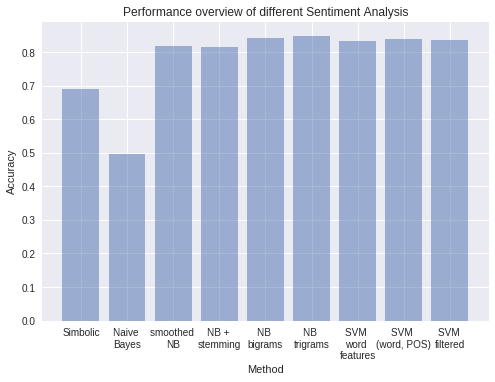

In [31]:
#Plots all the results together for a nice overview =)
method = ('Simbolic', 'Naive \nBayes' ,'smoothed \nNB', 'NB + \nstemming', 
          'NB \nbigrams', 'NB \ntrigrams', 'SVM \nword \nfeatures', 
          'SVM \n(word, POS)', 'SVM \nfiltered')

y_pos = np.arange(len(method))

performance = [token_accuracy, 
               NB_normal, 
               smoothed_NB[0],
               stem_NB[0],
               bigrams_NB[0],
               trigrams_NB[0],
               SVM_word[0],
               SVM_wp[0],
               SVM_sw[0]]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, method)
plt.ylabel('Accuracy')
plt.xlabel('Method')
plt.title('Performance overview of different Sentiment Analysis')
 
plt.show()


This practice was really interesting to experience how rather simple techniques can be quite effective in extracting the overall sentiment of a document. Even bye completely ignoring sentence structure and the relationship between words. 

1.   *Symbolic approach with sentiment lexicon*. The features aim to encode the sentiment carried by different words in proportion to their count in each review. Sentiment weighting can be included, however, we saw that the unweighted approach is about as effective. It reaches almost 70% accuracy, which is not ideal, but surprisingly good considering the simplicity of the technique. The biggest limitation is we are bounded by the sentiment lexicon. If it is imprecise or has too few words the sentiment extraction may lose a great deal of performance. It also cannot be scaled for other languages. The next two techniques go around this limitation.

2.   *Naive Bayes Classifier*. It attempts to capture the sentiment from the choice of words in each review. The features don't take any pre-assigned sentiment to the words. The information encoded by the feature vectors is the likelihood of a word choice given a class. The first surprise was to see that the Naive Bayes classifier performs as bad as a coin toss if no smoothing is used.  

      Smoothing takes its accuracy to 82%, which surprised us because the classifier simply ignores the interaction between words. Stemming was used as an attempt to lower the dimensions of the feature vectors. To take the word order in consideration n-grams were also used. None of them showed a significant difference in performance. We were expecting otherwise, as they attempt to capture aspects of the language that the Naive Bayes is ignorant of. 
      
3.   *Support Vector Machines*. This classic machine learning algorithm performed significantly better than Naive Bayes, even though the improvement wasn't impressive considering the increase in algorithm complexity. The features are the word counts themselves. The information encoded by the feature vector is rather abstract. Each feature vector is a point in the vocabulary space and it is assumed it is possible to find a hyperplane that separates the positive reviews from the negative ones.

     The features were modified to include the POS tags, however, no improvement was seen. That is expected because the POS tags do not carry any information about the meaning of the word, only about the grammatical role of that word in that sentence. An attempt to lower the dimension of the feature vectors was to discard all words that carry no relevant meaning. That can be seen as striping away dimensions in which the data cannot be linearly separated. That did not help either, which was against our intuition.

All techniques and features used share one main limitation. They have no means to take into consideration the context and the relationship between words. They suppose the presence of a set of words is enough to draw relevant conclusions about the overall sentiment of the review. 

# Submission 


In [0]:
# Write your names and student numbers here:
# Victor Zuanazzi 12325724
# Mahsa Mojtahedi 12166510

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Also save your notebook as a Github Gist. Get it by choosing `File -> Save as Github Gist`.  Make sure that the gist has a secret link (not public).
- Check if your answers are all included in the file you submit (e.g. check the Github Gist URL)
- Submit your .ipynb file and link to the Github Gist via *Canvas*. One submission per group. 